In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import quad
from scipy.misc import derivative
import numdifftools as nd
from numpy import cos, sin

In [167]:
# Constants given by the problem
n = 10  # number of segments
beta = 0.5  # design input parameter
L = 10  # assuming L is one wavelength of the sinusoidal wave

# (14) Calculate the lengths of the curved segments c and the straight segments l
c = L / n * beta
l = L / n * (1 - beta)

In [168]:
def z(x, L):
    """Sinusoidal centerline curve function."""
    # return np.sin(2 * np.pi * x / L)
    return np.sin(2 * np.pi * x / L) + 1/100 * x**2 + 1/2 * x
    # return np.sin(2 * np.pi * x / L)

def dz_dx(x, L):
    """Slope."""
    z_wrapped = lambda x: z(x, L)
    derivative = nd.Derivative(z_wrapped)
    return derivative(x)

def arc_length_integral(x, L):
    """Calculate the integral of the arc length from 0 to x."""
    # Use dz_dx directly inside the integral
    result, _ = quad(lambda x_prime: np.sqrt(1 + dz_dx(x_prime, L)**2), 0, x)
    return result

def get_x(s, L):
    """Find x coordinate for a given arc length s."""
    func_to_solve = lambda x: arc_length_integral(x, L) - s
    x_initial_guess = s  # Initial guess for x
    x_solution, = fsolve(func_to_solve, x_initial_guess)
    return x_solution

# # Example usage
# L = 10  # Example value for L
# s = 2   # Example arc length to find x for
# x_solution = get_x(s, L)
# z_value = z(x_solution, L)  # Calculate z using the original function

# print(f"x: {x_solution}, z: {z_value}")


In [169]:
def slope_to_unit_vector(slope):
    # Calculate the magnitude
    magnitude = np.sqrt(1 + slope**2)
    # Normalize the vector -> unit vector.
    unit_vector = np.array([1,0, slope,1]) / magnitude
    return unit_vector

# Initialize lists to store calculated values.
s = []  # Sampled arc length values.
s_x = []  # x-coordinates corresponding to the arc lengths.
pd = []  # Homogeneous xyz coordinates for each arc length.
diff_pd = []  # Unit vectors representing the direction of the slope at each arc length.

# Loop to compute values for each of n segments plus the start/end points (n+1 total).
for j in range(n+1):
    # Calculate the current arc length s[j].
    sj = j/n * L
    # Determine the x-coordinate corresponding to the current arc length.
    sj_x = get_x(sj, L)
    # Compute the z-coordinate using the curve's equation.
    sj_z = z(sj_x, L)
    # Store the current point in homogeneous coordinates.
    pdj = np.array([sj_x, 0, sj_z, 1])
    # Calculate the slope of the curve at the current x-coordinate.
    slope_j = dz_dx(sj_x, L)
    # Convert the slope into a unit vector representing the curve's direction.
    diff_pdj = slope_to_unit_vector(slope_j)

    # Append calculated values to their respective lists.
    s.append(sj)
    s_x.append(sj_x)
    pd.append(pdj)
    diff_pd.append(diff_pdj)

# print(s)
print(s_x)
print(pd)
# print(diff_pd)
# print(len(diff_pd))

[0.0, 0.6670806062085591, 1.3667648705639603, 2.1407032872131544, 3.0257241193265387, 4.002769875723985, 5.002312370160446, 6.001196850899433, 6.965211382197496, 7.818231798976556, 8.552154694017974]
[array([0., 0., 0., 1.]), array([0.66708061, 0.        , 0.7449645 , 1.        ]), array([1.36676487, 0.        , 1.45909827, 1.        ]), array([2.14070329, 0.        , 2.09080363, 1.        ]), array([3.02572412, 0.        , 2.55035001, 1.        ]), array([4.00276988, 0.        , 2.74798298, 1.        ]), array([5.00231237, 0.        , 2.74993457, 1.        ]), array([6.00119685, 0.        , 2.77234859, 1.        ]), array([6.96521138, 0.        , 3.02367212, 1.        ]), array([7.8182318 , 0.        , 3.54028706, 1.        ]), array([8.55215469, 0.        , 4.21814633, 1.        ])]


In [170]:
def bending_transformation(l, kj):
    th_j = kj * l 
    T_b_j = np.array([[cos(th_j), 0, sin(th_j), (1 - cos(th_j)) / kj],
                        [0, 1, 0, 0],
                        [-sin(th_j), 0, cos(th_j), sin(th_j) / kj],
                        [0, 0, 0, 1]
                    ])
    return T_b_j

def local_translation(c):
    Tr_j = np.array([[1, 0, 0, 0],
                    [0, 1, 0, 0],
                    [0, 0, 1, c],
                    [0, 0, 0, 1]
                    ])
    return Tr_j


In [171]:
def error_function(diff_pdj, pdj, c, l, kj, cumulative_T):
    """
    Calculates the error scalar representing the deviation between 
    the desired position and the actual position of a point along a robotic arm or similar system.
    
    Parameters:
    - diff_pdj: The differential vector for the desired position of joint j.
    - pdj: The desired position vector of joint j.
    - c: Constant parameter for local translation transformation.
    - l: Length parameter for bending transformation.
    - kj: Curvature parameter for the segment.
    - cumulative_T: The cumulative transformation matrix up to joint j.
    
    Returns:
    - ej: The error scalar indicating the deviation.
    """
    # Define the 90-degree rotation matrix around the y-axis to get the normal vector
    Ry_90 = np.array([[0, 0, 1, 0], 
                      [0, 1, 0, 0], 
                      [-1, 0, 0, 0],
                      [0, 0, 0, 1]])
    Nj = Ry_90 @ diff_pdj  # Calculate the normal vector
    
    # Update cumulative transformation matrix with current segment parameters
    cumulative_T, _ = udpate_cumulative_T(c, l ,kj, cumulative_T)

    p0 = np.array([0,0,0,1])  # Define the starting point
    pj = cumulative_T @ p0  # Calculate the current position of the joint

    ej_vec = pj - pdj  # Compute the vector indicating error direction

    ej = Nj.T @ ej_vec  # Calculate the scalar error by projecting the error vector onto the normal vector
    return ej

def udpate_cumulative_T(c, l , kj, cumulative_T):
    """
    Updates the cumulative transformation matrix based on the current segment parameters.
    
    Parameters:
    - c: Constant parameter for local translation transformation.
    - l: Length parameter for bending transformation.
    - kj: Curvature parameter for the segment.
    - cumulative_T: The current cumulative transformation matrix.
    
    Returns:
    - cumulative_T: The updated cumulative transformation matrix.
    - cumulative_T_intermediate: The updated (intermediate) cumulative transformation matrix.
    """
    T_b_j = bending_transformation(l, kj)  # Calculate bending transformation matrix
    T_r_j = local_translation(c)  # Calculate local translation transformation matrix
    cumulative_T_intermediate = cumulative_T @ T_b_j # Update cumulative transformation matrix (after bending transformation)
    cumulative_T = cumulative_T @ T_b_j @ T_r_j  # Update cumulative transformation matrix
    return cumulative_T, cumulative_T_intermediate

def error_func_wrapper(diff_pdj, pdj, c, l, kj_array,cumulative_T):
        # Call error_function with kj_array[0] to treat it as a scalar
        return error_function(diff_pdj, pdj, c, l, kj_array[0],cumulative_T)

# Initialization of parameters for optimization
p = []  # List to store position vectors
k = []  # List to store curvature solutions
p0 = np.array([0, 0, 0, 1]) # inital position vector p[0]
p.append(p0) # Initialize the starting point for the first segment
cumulative_T = np.eye(4)  # Initialize cumulative transformation matrix as identity matrix

# Iterate through each segment to optimize its curvature
for j in range(1, n + 1):
    kj_i_arr = np.array([1/L])  # initial guess for the segment's curvature

    # Solve for the optimal curvature, kj
    error_func = lambda kj: error_function(diff_pd[j], pd[j], c, l, kj[0], cumulative_T) # define error function
    kj_sol, = fsolve(error_func, kj_i_arr, xtol=1e-10, maxfev=1000)
    k.append(kj_sol)  # store the optimized curvature value

    # Update the cumulative transformation matrix
    cumulative_T, cumulative_T_intermediate = udpate_cumulative_T(c, l, kj_sol, cumulative_T)

    # Append intermediate and total position vectors for the current segment
    p.append(cumulative_T_intermediate @ p0)  # Intermediate position vector
    p.append(cumulative_T @ p0)  # Total position vector 

    print(f"Segment {j}, Curvature: {kj_sol}")

# Final output showing the solved curvatures and optimized position vectors
# print(f"solved kj:{k}, Optimized p:{p}")


Segment 1, Curvature: 1.9327968450713051
Segment 2, Curvature: -0.5194729514474332
Segment 3, Curvature: 0.4573414021451921
Segment 4, Curvature: 0.381417864593654
Segment 5, Curvature: 0.6149335369008866
Segment 6, Curvature: 0.3464608431308999
Segment 7, Curvature: -0.13531897430246964
Segment 8, Curvature: -0.5519709447362584
Segment 9, Curvature: -0.593222296913668
Segment 10, Curvature: -0.354174821138919


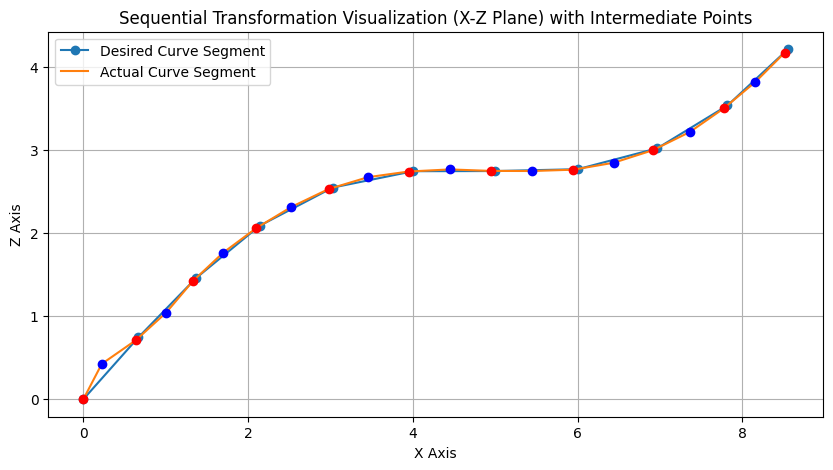

In [192]:
p = np.array(p)
pd = np.array(pd)
desired_length = pd[-1,0]
# print(pd[-1,0])
desired_x = np.linspace(0, desired_length, 1000)  # Generate 1000 points along x from 0 to L
desired_z = z(desired_x, L)
    
plt.figure(figsize=(10, 5))
# plt.plot(desired_x, desired_z , linestyle='-',  linewidth=2, label='Desired Curve ')
plt.plot(pd[:, 0], pd[:, 2], marker='o', linestyle='-', label='Desired Curve Segment')
# plt.plot(p[:, 0], p[:, 2], marker='o', linestyle='-', label='Actual Curve Segment')
plt.plot(p[:, 0], p[:, 2], linestyle='-', label='Actual Curve Segment')

# Loop through the points and plot even-numbered points with a different color
for i in range(len(p)):
    if i % 2 == 0:  # Check if the index is even
        plt.plot(p[i, 0], p[i, 2], marker='o', color='red')  # Change 'red' to your preferred color for even points
    else:
        plt.plot(p[i, 0], p[i, 2], marker='o', color='blue')  # This plots odd-numbered points, change 'blue' as needed

plt.legend()
plt.xlabel('X Axis')
plt.ylabel('Z Axis')
plt.title('Sequential Transformation Visualization (X-Z Plane) with Intermediate Points')
plt.grid(True)
plt.show()


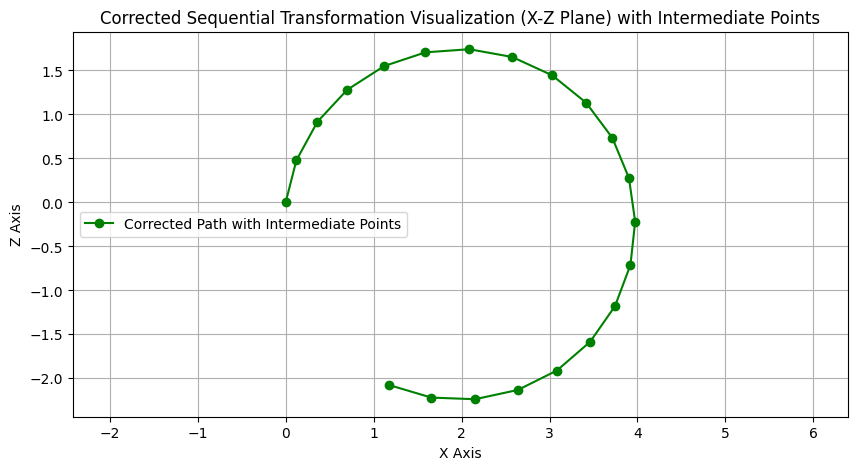

In [173]:
# test k
cumulative_T = np.eye(4)
k_test = np.array([3,3,3,3,3,3,3,3,3,3,3])
p_test =[]
p_test_notched = [] 
pj_1 = np.array([0, 0, 0, 1])
points_corrected_sequential_with_intermediates = [pj_1[:3]]

for i in range(1,len(k)+1):
    if i-1==0:
        p_test.append(np.array([0,0,0,1]))
    T_b_j = Tb(l,k_test[i]/3)
    
    cumulative_T = cumulative_T @ T_b_j
    intermediate_pj = cumulative_T @ pj_1
    points_corrected_sequential_with_intermediates.append(intermediate_pj[:3])
    
    # Apply the corrected translation in the local frame after bending
    T_r_j = Tr(c)
    cumulative_T = cumulative_T @ T_r_j
    pj = cumulative_T @ pj_1
    
    # Add the final point after translation to the list
    points_corrected_sequential_with_intermediates.append(pj[:3])

points_corrected_sequential_with_intermediates = np.array(points_corrected_sequential_with_intermediates)
# Plotting the corrected points with intermediates
plt.figure(figsize=(10, 5))
plt.plot(points_corrected_sequential_with_intermediates[:, 0], points_corrected_sequential_with_intermediates[:, 2], marker='o', linestyle='-', color='green', label='Corrected Path with Intermediate Points')

# Setting the aspect ratio to be equal for uniform scale visualization
plt.axis('equal')

plt.xlabel('X Axis')
plt.ylabel('Z Axis')
plt.title('Corrected Sequential Transformation Visualization (X-Z Plane) with Intermediate Points')
plt.grid(True)
plt.legend()
